In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from quant_met import hamiltonians, plotting, utils
import numpy as np
import glob

In [2]:
lattice_constant = np.sqrt(3)

all_K_points = 4 * np.pi / (3 * lattice_constant) * np.array([
    (np.sin(i * np.pi / 6), np.cos(i * np.pi / 6)) for i in [1, 3, 5, 7, 9, 11]]
)

BZ_grid = utils.generate_uniform_grid(10, 10, all_K_points[1], all_K_points[5], origin=np.array([0, 0]))

Gamma = np.array([0, 0])
M = np.pi / lattice_constant * np.array([1, 1 / np.sqrt(3)])
K = 4 * np.pi / (3 * lattice_constant) * np.array([1, 0])

points = [(M, 'M'), (Gamma, r'\Gamma'), (all_K_points[1], 'K')]

band_path, band_path_plot, ticks, labels = plotting.generate_bz_path(points, number_of_points=1000)

In [18]:
def plot_for_V(V_list, base_path):
    mu_files_test = glob.glob(f'gap_plots_data/{base_path}/V_{V_list[0]}_*.csv')
    
    fig, axs = plt.subplots(nrows=4*len(V_list), ncols=len(mu_files_test), figsize=(len(mu_files_test)*5, 4*5*len(V_list)))
    #fig, axs = plt.subplots(nrows=2*len(V_list), ncols=len(mu_files_test), figsize=(len(mu_files_test)*5, 2*5*len(V_list)))
    

    for V_index, V in enumerate(V_list):
        mu_files = glob.glob(f'gap_plots_data/{base_path}/V_{V}_*.csv')
        
        mu_list = sorted([float(x.split('/')[-1].split('_')[-1].strip('.csv')) for x in mu_files], reverse=True)
        
        for mu_index, mu in enumerate(mu_list):
            with open(f'gap_plots_data/{base_path}/V_{V}_mu_{mu}.csv', 'r') as f:
                data = pd.read_csv(f, usecols=['U', 'delta_0', 'delta_1', 'delta_2'])
            
            for row in data.iterrows():
                row[1].loc[['delta_0', 'delta_1', 'delta_2']] *= np.sign(row[1].loc['delta_1'])
            
            if len(mu_list) == 1:
                ax = axs[4*V_index]
            else:
                ax = axs[4*V_index, mu_index]

            ax.plot(data['U'], data['delta_0'], 'x--', label='$Gr_A$ (site with attached X atom)', alpha=0.8)
            ax.plot(data['U'], data['delta_1'], 'x--', label='$Gr_B$', alpha=0.8)
            ax.plot(data['U'], data['delta_2'], 'x--', label='$X$', alpha=0.8)

            ax.set_ylim(bottom=0)
            ax.set_xlim(left=0)
            ax.grid(True)
            ax.set_xlabel(r'$U\ [t]$')
            #ax.set_xlabel(r'$U_X\ [t]$')
            ax.set_ylabel(r'$\Delta\ [t]$')
            ax.legend()
            ax.set_title(f'$V = {V}, \\mu = {mu}$')
            #ax.set_title(f'$V = {V}, \\mu = {mu}, U_gr = 1$')

            if len(mu_list) == 1:
                ax = axs[4*V_index+1]
            else:
                ax = axs[4*V_index+1, mu_index]
            
            egx_h = hamiltonians.EGXHamiltonian(t_gr=1, t_x=0.01, a=lattice_constant, V=V, mu=mu, U_gr=0, U_x=0, delta=np.array([data['delta_0'][0], data['delta_1'][0], data['delta_2'][0]]))
            
            bdg_energies, _ = egx_h.diagonalize_bdg(k=band_path)
            
            bdg_energies = bdg_energies.T
            
            plotting.plot_bandstructure(bands=bdg_energies, k_point_list=band_path_plot, ticks=ticks, labels=labels, fig_in=fig, ax_in=ax)
            
            if len(mu_list) == 1:
                ax = axs[4*V_index+2]
            else:
                ax = axs[4*V_index+2, mu_index]
                
            quantum_metric_list = []
            
            for index, U in enumerate(data['U']):
                egx_h = hamiltonians.EGXHamiltonian(t_gr=1, t_x=0.01, a=lattice_constant, V=V, mu=mu, U_gr=0, U_x=0, delta=np.array([data['delta_0'][index], data['delta_1'][index], data['delta_2'][index]]))
                quantum_metric = hamiltonians.calculate_quantum_metric(h=egx_h, k_grid=BZ_grid, band=0)
                print(quantum_metric)
                quantum_metric_list.append(quantum_metric[0, 0])
                
            quantum_metric_list = np.array(quantum_metric_list)
            
            ax.plot(data['U'], data['U'].to_numpy() * quantum_metric_list, 'x--')
            
            if len(mu_list) == 1:
                ax = axs[4*V_index+3]
            else:
                ax = axs[4*V_index+3, mu_index]
            
            D_S_list_conv = []
            D_S_list_geom = []
            
            for index, U in enumerate(data['U']):
                egx_h = hamiltonians.EGXHamiltonian(t_gr=1, t_x=0.01, a=lattice_constant, V=V, mu=mu, U_gr=0, U_x=0, delta=np.array([data['delta_0'][index], data['delta_1'][index], data['delta_2'][index]]))
                D_S = hamiltonians.calculate_superfluid_weight(egx_h, k_grid=BZ_grid, direction_1='x', direction_2='y')
                D_S_list_conv.append(D_S[0])
                D_S_list_geom.append(D_S[1])
            
            D_S_list_geom = np.abs(np.array(D_S_list_geom))
            D_S_list_conv = np.abs(np.array(D_S_list_conv))
            
            ax.fill_between(data['U'], D_S_list_geom, y2=0, label='geom')
            ax.fill_between(data['U'], D_S_list_geom + D_S_list_conv, y2=D_S_list_geom, label='conv')
            
            """
            ax.plot(data['U'], D_S_list_geom, 'x--', label='geom')
            ax.plot(data['U'], D_S_list_conv, 'x--', label='conv')
            ax.plot(data['U'], D_S_list_geom + D_S_list_conv, 'x--', label='sum')
            """
            
            ax.plot(data['U'], D_S_list_geom + D_S_list_conv, 'x--', label='$D_S$')
            ax.legend()

    return fig

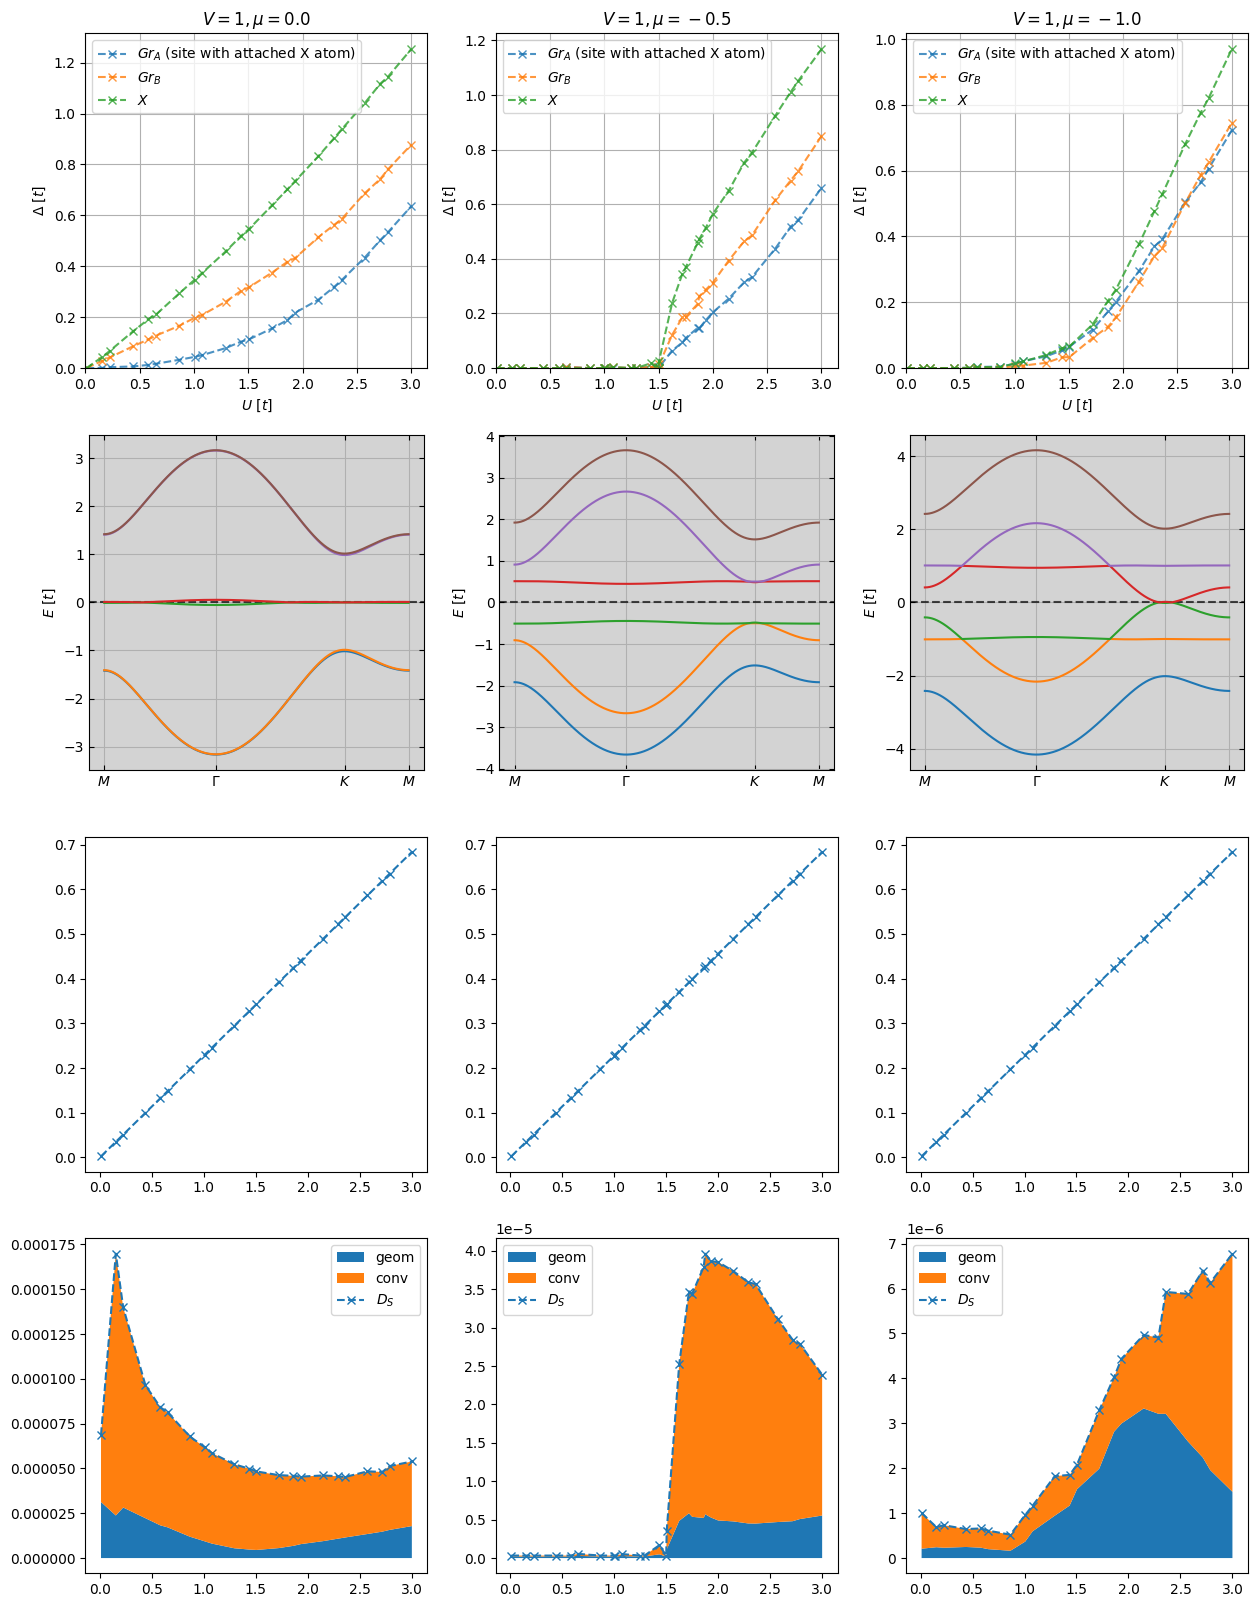

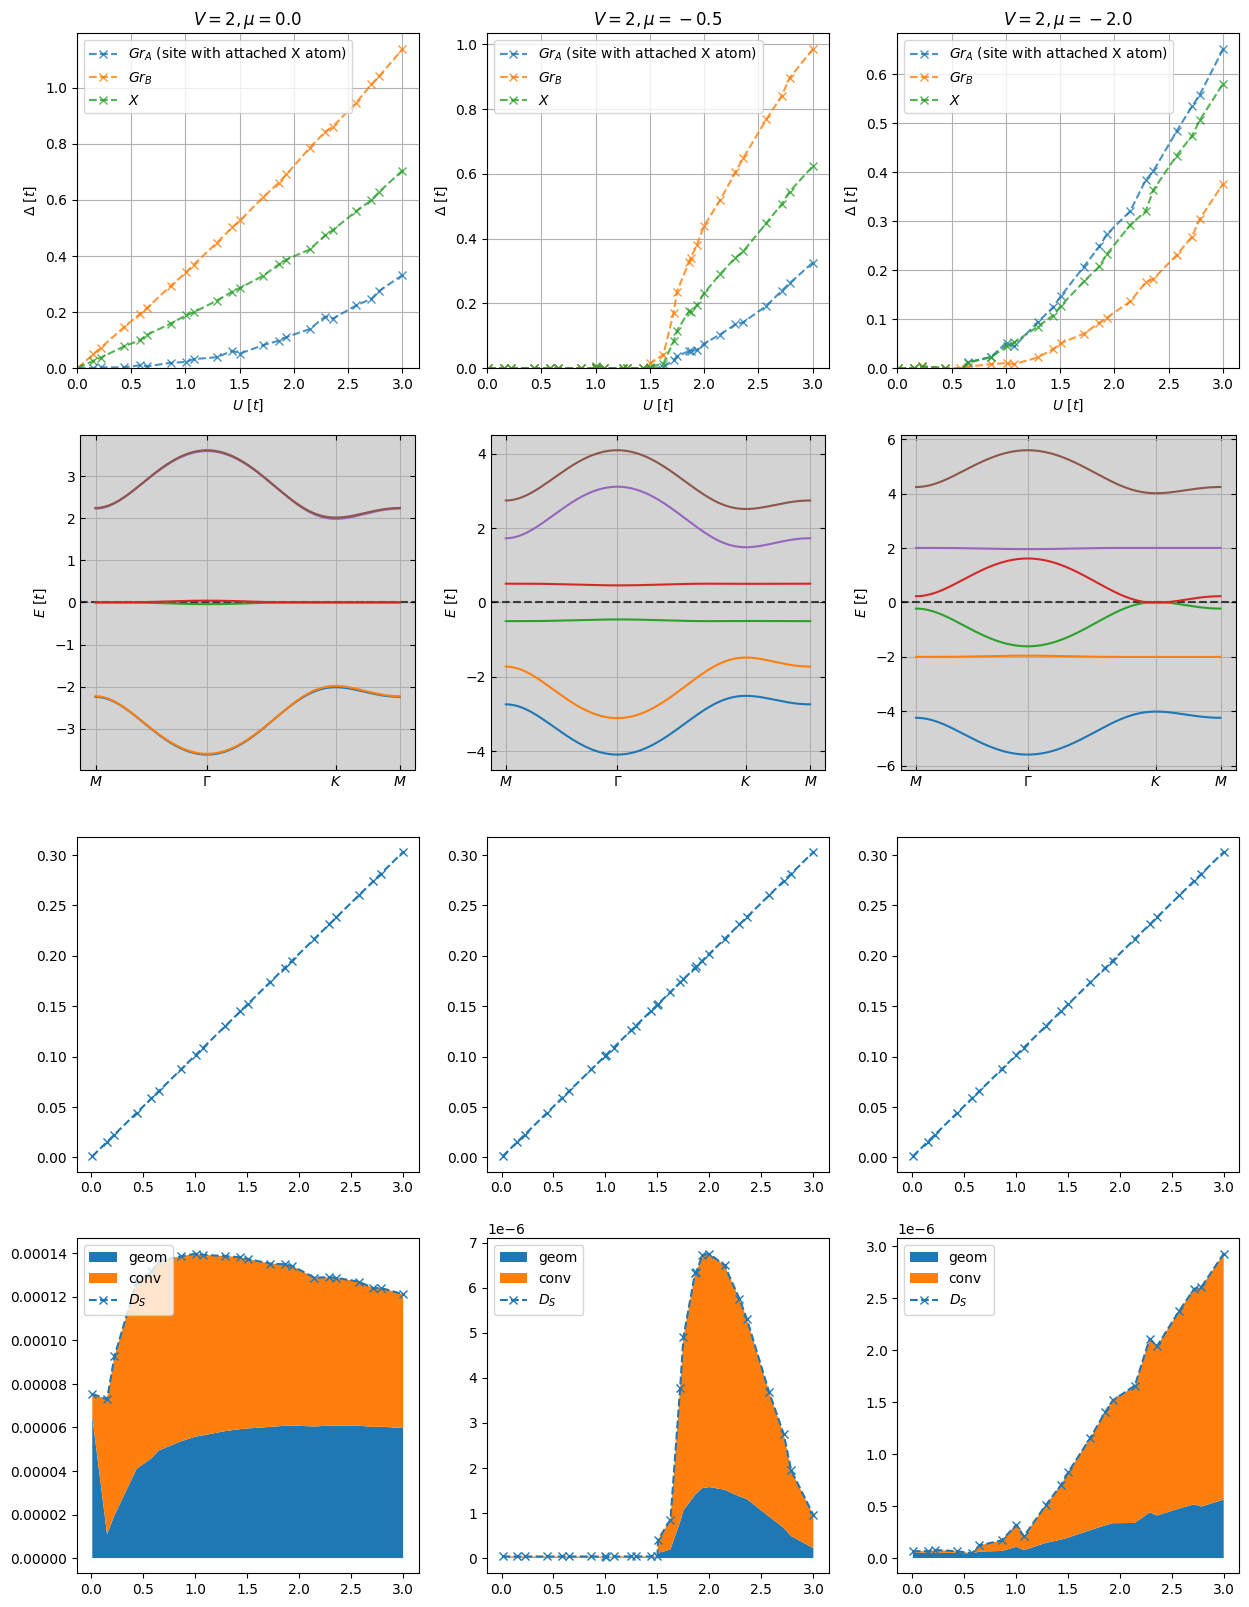

In [12]:
fig = plot_for_V([1], 'egx/gap_size_vs_U_uniform')
fig.savefig(f'gap_plots_with_bdg/gap_size_vs_U_egx_uniform_U_V_1.pdf', bbox_inches='tight')

fig = plot_for_V([2], 'egx/gap_size_vs_U_uniform')
fig.savefig(f'gap_plots_with_bdg/gap_size_vs_U_egx_uniform_U_V_2.pdf', bbox_inches='tight')

[[0.02329019 0.00661282]
 [0.00661282 0.03123052]]
[[0.02329019 0.00661282]
 [0.00661282 0.03123052]]
[[0.02329019 0.00661282]
 [0.00661282 0.03123052]]
[[0.02329019 0.00661282]
 [0.00661282 0.03123052]]
[[0.02329019 0.00661282]
 [0.00661282 0.03123052]]
[[0.02329019 0.00661282]
 [0.00661282 0.03123052]]
[[0.02329019 0.00661282]
 [0.00661282 0.03123052]]
[[0.02329019 0.00661282]
 [0.00661282 0.03123052]]
[[0.02329019 0.00661282]
 [0.00661282 0.03123052]]
[[0.02329019 0.00661282]
 [0.00661282 0.03123052]]
[[0.02329019 0.00661282]
 [0.00661282 0.03123052]]
[[0.02329019 0.00661282]
 [0.00661282 0.03123052]]
[[0.02329019 0.00661282]
 [0.00661282 0.03123052]]
[[0.02329019 0.00661282]
 [0.00661282 0.03123052]]
[[0.02329019 0.00661282]
 [0.00661282 0.03123052]]
[[0.00634021 0.00182105]
 [0.00182105 0.00848979]]
[[0.00634021 0.00182105]
 [0.00182105 0.00848979]]
[[0.00634021 0.00182105]
 [0.00182105 0.00848979]]
[[0.00634021 0.00182105]
 [0.00182105 0.00848979]]
[[0.00634021 0.00182105]
 [0.00

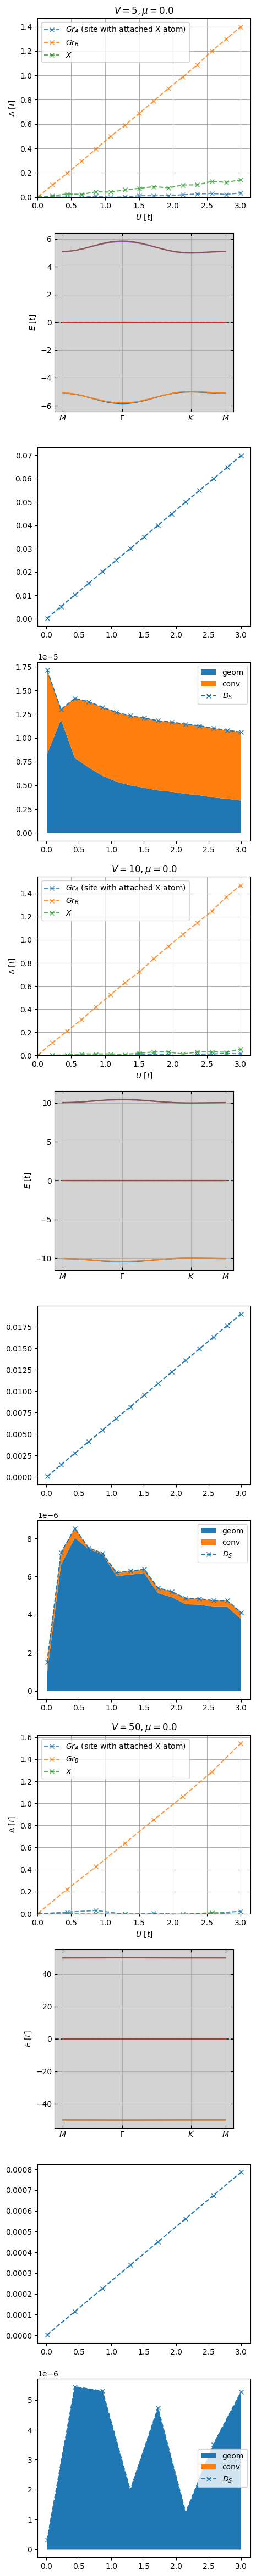

In [21]:
fig = plot_for_V([5, 10, 50], 'egx/gap_size_vs_U_uniform')
fig.savefig(f'gap_plots_with_bdg/gap_size_vs_U_egx_uniform_U_large_V.pdf', bbox_inches='tight')

IndexError: index 3 is out of bounds for axis 1 with size 3

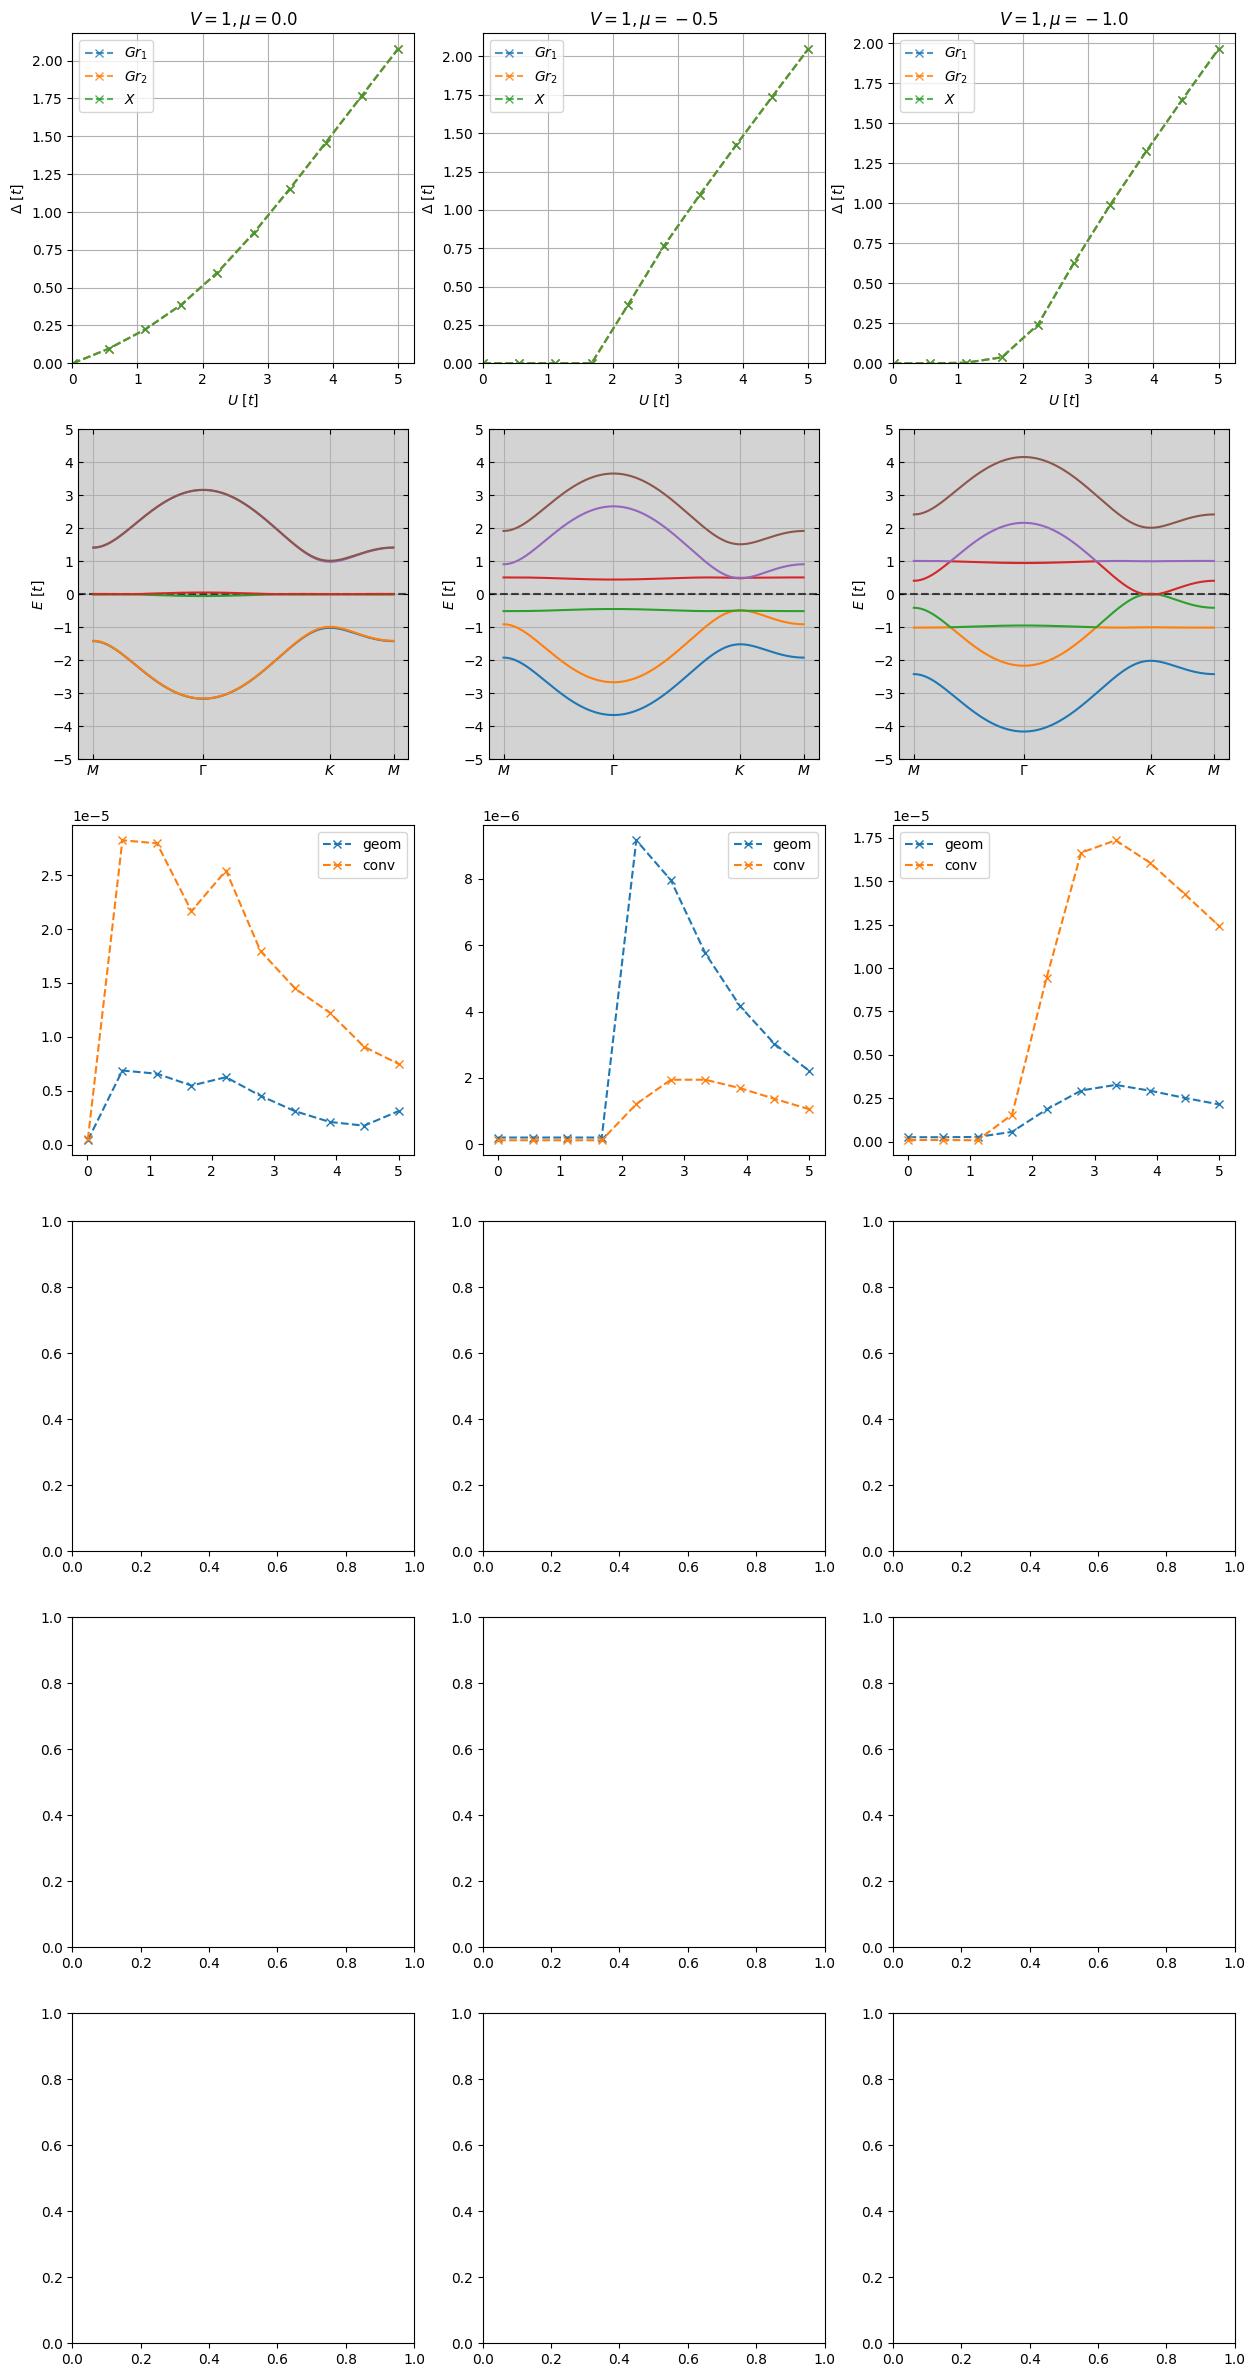

In [4]:
fig = plot_for_V([1, 2], 'egx/gap_size_vs_U_uniform_pairing_constraint')
fig.savefig(f'gap_plots/gap_size_vs_U_egx_uniform_pairing_constraint.pdf')

In [24]:
def plot_band_basis(V_list, base_path):
    mu_list = [0, -0.5, -1, -1.5]
    
    fig, axs = plt.subplots(nrows=len(V_list), ncols=len(mu_list), figsize=(8*len(mu_list), 5*len(V_list)))
    
    for V_index, V in enumerate(V_list):
        for mu_index, mu in enumerate(mu_list):
            with open(f'gap_plots_data/{base_path}/V_{V}_mu_{mu}.csv', 'r') as f:
                data = pd.read_csv(f, index_col=0)
            ax = axs[V_index, mu_index]
            
            results = dict.fromkeys(data['U'], 0)
            
            #band_path = np.array([[0, 0]])
            #band_path_plot = np.array([0])
            
            for index, row in data.iterrows():
                results_tmp = pd.DataFrame(index=band_path_plot, columns=['d_11', 'd_12', 'd_13', 'd_22','d_23', 'd_33'])
                U = row['U']
                
                delta = row.loc[['delta_0', 'delta_1', 'delta_2']].to_numpy()
                egx_h = hamiltonians.EGXHamiltonian(t_gr=1, t_x=0.01, a=lattice_constant, V=V, mu=mu, U_gr=U, U_x=U)
                
                _, bloch = egx_h.generate_bloch(band_path)
                
                for k_index, G in enumerate(bloch):
                    # What about imaginary part?
                    delta_band_basis = np.absolute(G @ np.eye(3) * delta @ np.conjugate(G).T)
                    #delta_band_basis = np.real(G @ np.eye(3) * delta @ np.conjugate(G).T)
                    results_tmp.iloc[k_index] = delta_band_basis[np.triu_indices(3)]
                
                results[U] = results_tmp 
                
            U = list(results.keys())[3]
            df = results[U]
            
            ax.plot(df.index, df['d_11'], label='$\\Delta_{11}$', color='black')
            ax.plot(df.index, df['d_12'], label='$\\Delta_{12}$', color='blue')
            ax.plot(df.index, df['d_13'], label='$\\Delta_{13}$', color='orange')
            ax.plot(df.index, df['d_22'], label='$\\Delta_{22}$', color='green')
            ax.plot(df.index, df['d_23'], label='$\\Delta_{23}$', color='fuchsia')
            ax.plot(df.index, df['d_33'], label='$\\Delta_{33}$', color='crimson')
            
            """
            for U, df in results.items():
                ax.plot(df.index, df['d_11'], label=f'$U = {U:.2f}$', color='black')
                ax.plot(df.index, df['d_12'], label=f'$U = {U:.2f}$', color='blue')
                ax.plot(df.index, df['d_13'], label=f'$U = {U:.2f}$', color='orange')
                ax.plot(df.index, df['d_22'], label=f'$U = {U:.2f}$', color='green')
                ax.plot(df.index, df['d_23'], label=f'$U = {U:.2f}$', color='fuchsia')
                ax.plot(df.index, df['d_33'], label=f'$U = {U:.2f}$', color='fuchsia')
            """
             
            ax.set_xlim(left=0, right=1)
            ax.set_ylim(bottom=0)
            ax.set_ylabel(r'$\Delta$')
            ax.grid(True)
            ax.set_title(f'$V = {V}, \\mu = {mu}, U = {U:.2f}$')
            ax.set_xticks(ticks, labels)
            ax.legend()
               
    return fig

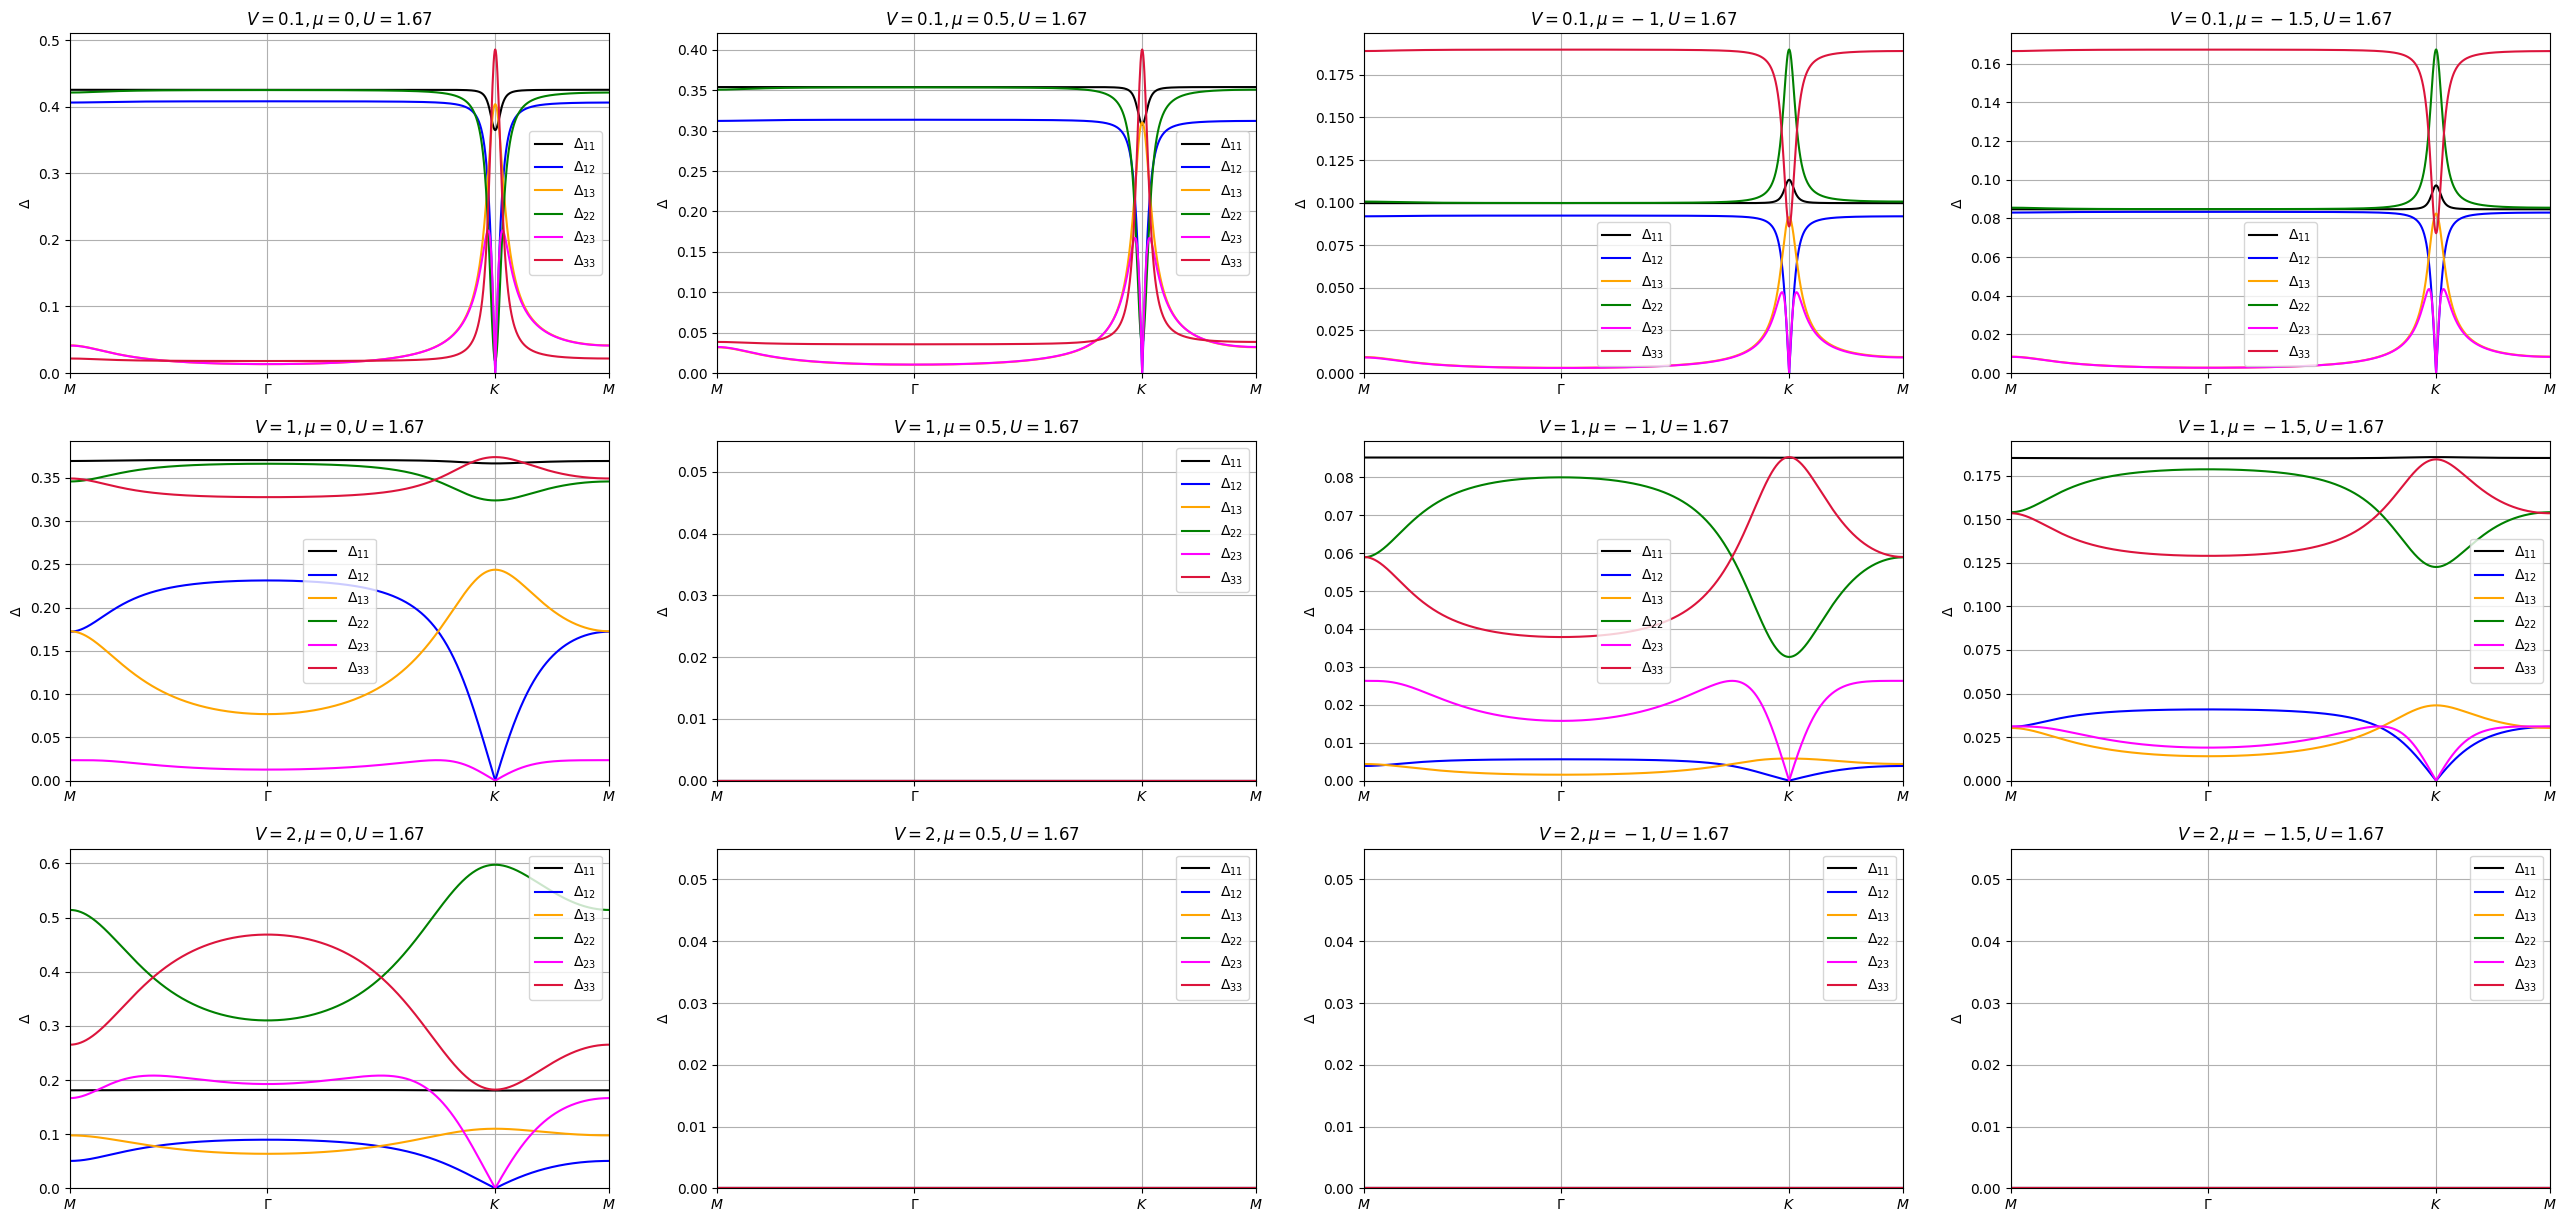

In [22]:
fig = plot_band_basis([0.1, 1, 2], 'egx/gap_size_vs_U_uniform')
fig.savefig('gap_plots/gap_size_k_space_band_basis.pdf', bbox_inches='tight')

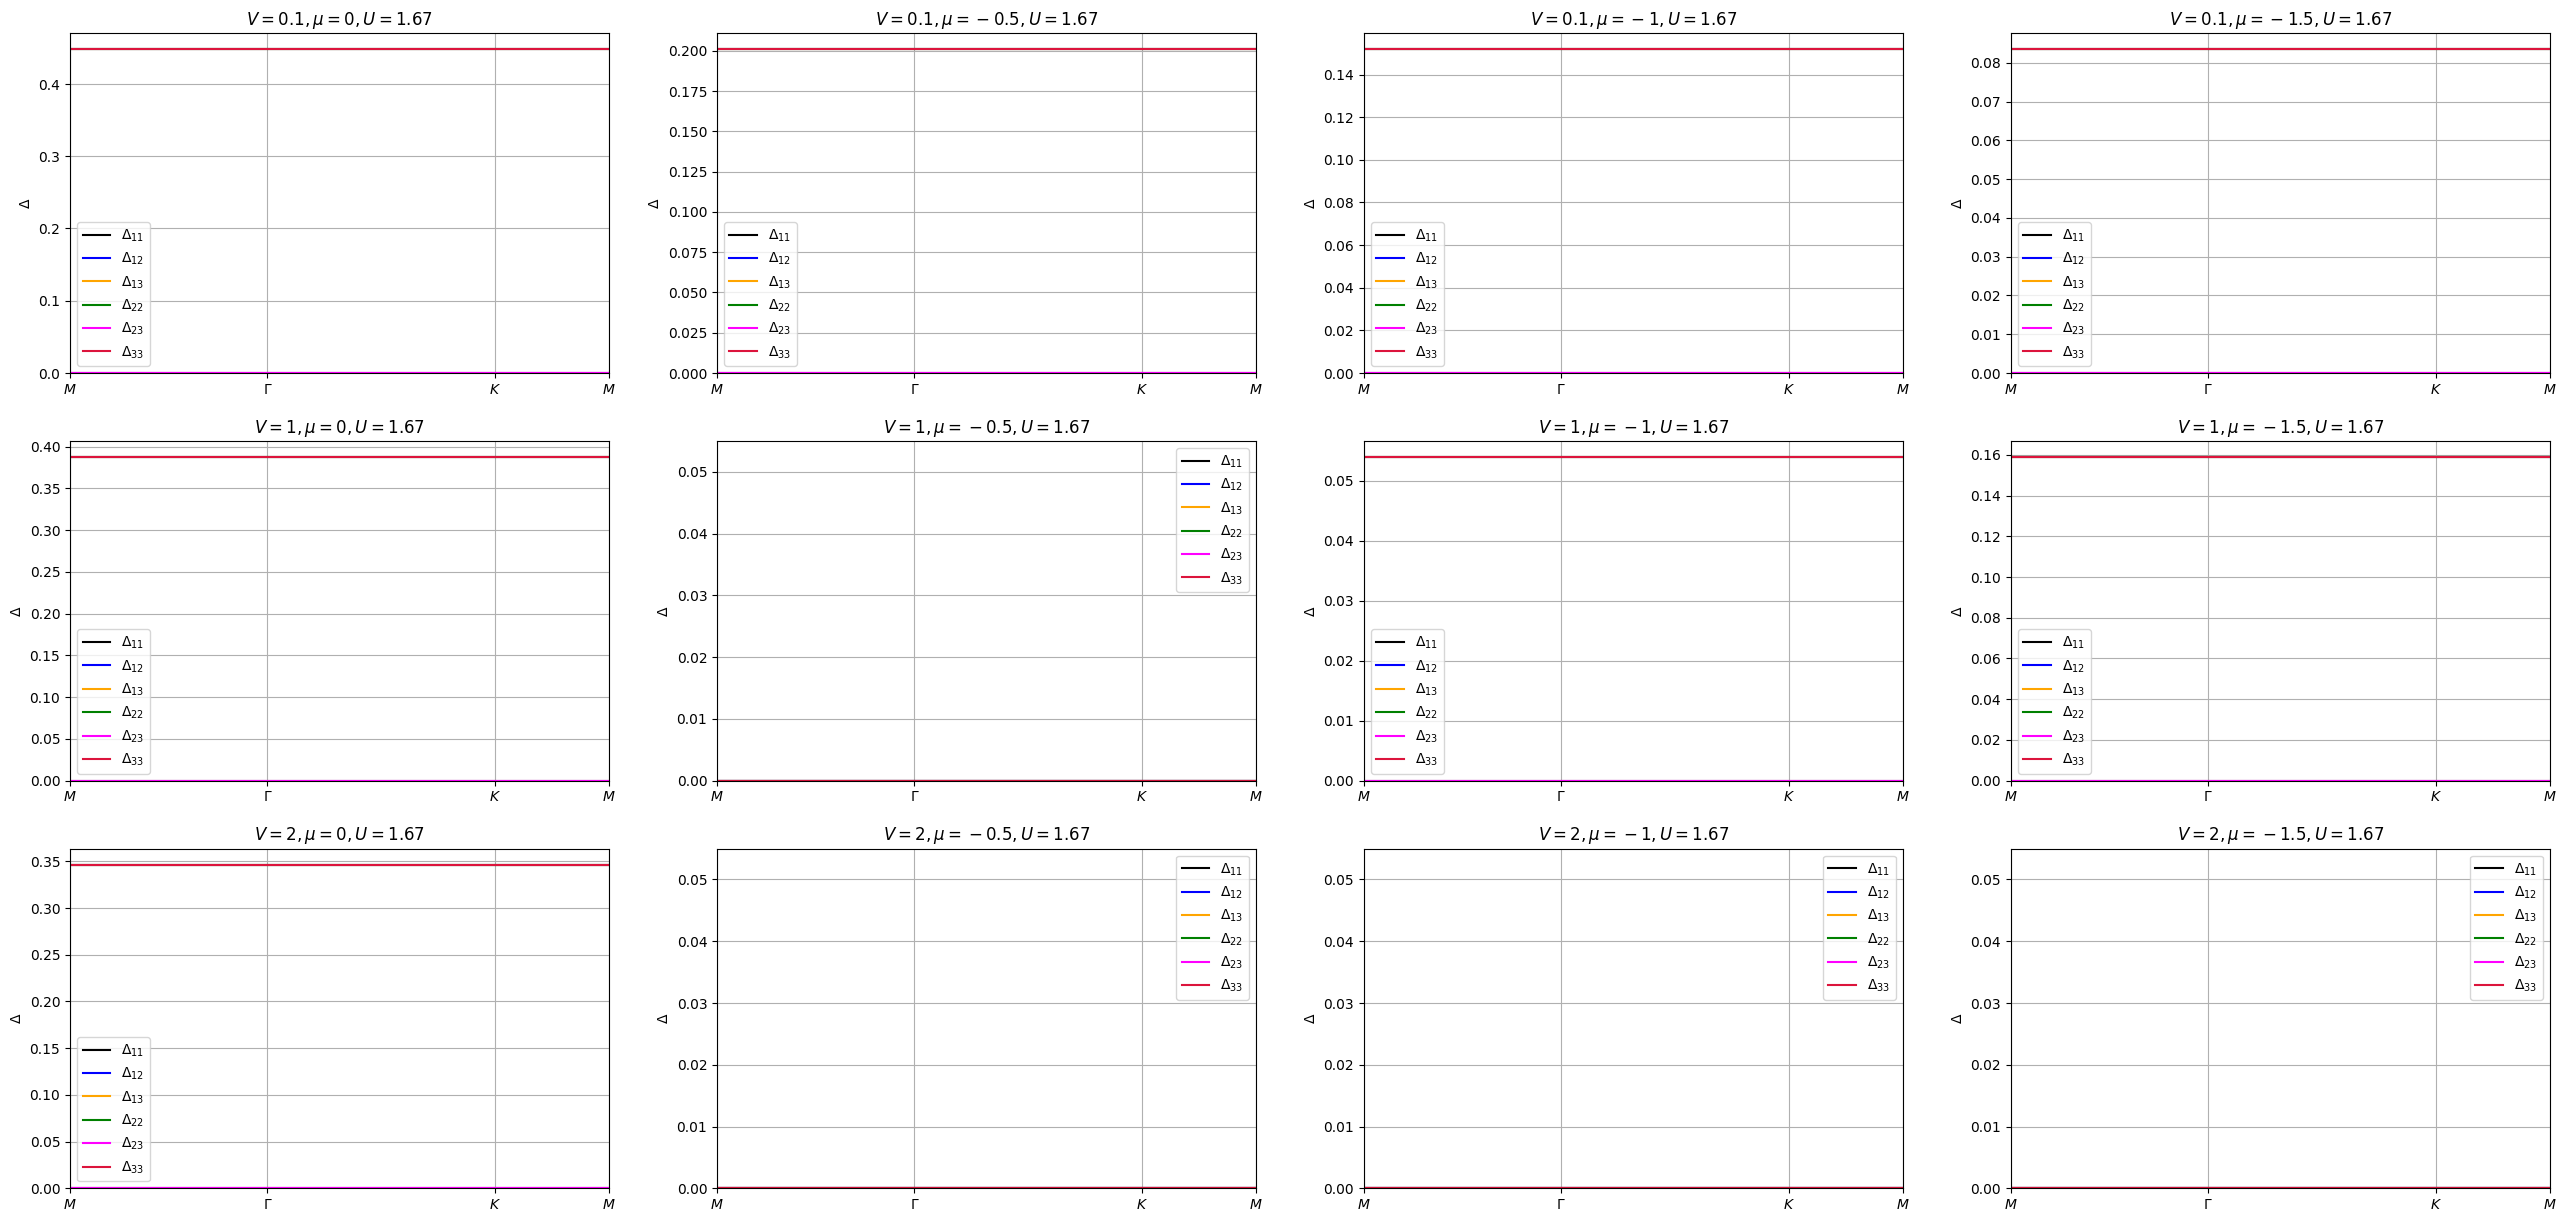

In [25]:
fig = plot_band_basis([0.1, 1, 2], 'egx/gap_size_vs_U_uniform_pairing_constraint')
fig.savefig('gap_plots/gap_size_k_space_band_basis_uniform_pairing_constraint.pdf', bbox_inches='tight')

In [82]:
def plot_band_basis_uniform_pairing(V_list, base_path):
    mu_list = [0, -0.5, -1, -1.5]

    fig, axs = plt.subplots(nrows=len(V_list), ncols=len(mu_list), figsize=(5*len(mu_list), 5*len(V_list)))

    for V_index, V in enumerate(V_list):
        for mu_index, mu in enumerate(mu_list):
            with open(f'gap_plots_data/{base_path}/V_{V}_mu_{mu}.csv', 'r') as f:
                data = pd.read_csv(f, index_col=0)
            ax = axs[V_index, mu_index]
            
            results = pd.DataFrame(index=data.index, dtype=np.float64, columns=['U', 'delta_0', 'delta_1', 'delta_2'])

            for index, row in data.iterrows():
                results_tmp = pd.DataFrame(index=band_path_plot, dtype=np.float64, columns=['d_11', 'd_12', 'd_13', 'd_22','d_23', 'd_33'])
                U = row['U']

                delta = row.loc[['delta_0', 'delta_1', 'delta_2']].to_numpy()
                egx_h = hamiltonians.EGXHamiltonian(t_gr=1, t_x=0.01, a=lattice_constant, V=V, mu=mu, U_gr=U, U_x=U)

                _, bloch = egx_h.generate_bloch(band_path)

                for k_index, G in enumerate(bloch):
                    # What about imaginary part?
                    delta_band_basis = np.absolute(G @ np.eye(3) * delta @ np.conjugate(G).T)
                    #delta_band_basis = np.real(G @ np.eye(3) * delta @ np.conjugate(G).T)
                    results_tmp.iloc[k_index] = delta_band_basis[np.triu_indices(3)]
                    
                rtol = 1e-10
                atol = 1e-14
                    
                assert np.allclose(results_tmp.loc[:, 'd_11'], results_tmp.loc[0, 'd_11'], rtol=rtol, atol=atol)
                assert np.allclose(results_tmp.loc[:, 'd_22'], results_tmp.loc[0, 'd_22'], rtol=rtol, atol=atol)
                assert np.allclose(results_tmp.loc[:, 'd_33'], results_tmp.loc[0, 'd_33'], rtol=rtol, atol=atol)
                assert np.allclose(results_tmp.loc[:, 'd_12'], 0, rtol=rtol, atol=atol)
                assert np.allclose(results_tmp.loc[:, 'd_13'], 0, rtol=rtol, atol=atol)
                assert np.allclose(results_tmp.loc[:, 'd_23'], 0, rtol=rtol, atol=atol)
                
                results.iloc[index] = np.array([U, results_tmp.loc[0, 'd_11'], results_tmp.loc[0, 'd_22'], results_tmp.loc[0, 'd_33']])
                
            ax.plot(data['U'], data['delta_0'], 'x--', label='$Gr_1$', alpha=0.8)
            ax.plot(data['U'], data['delta_1'], 'x--', label='$Gr_2$', alpha=0.8)
            ax.plot(data['U'], data['delta_2'], 'x--', label='$X$', alpha=0.8)

            ax.set_ylim(bottom=0, top=2.6)
            ax.set_xlim(left=0)
            ax.grid(True)
            ax.set_xlabel(r'$U\ [t]$')
            #ax.set_xlabel(r'$U_X\ [t]$')
            ax.set_ylabel(r'$\Delta\ [t]$')
            ax.legend()
            ax.set_title(f'$V = {V}, \\mu = {mu}$')
            #ax.set_title(f'$V = {V}, \\mu = {mu}, U_gr = 1$')
            
    return fig

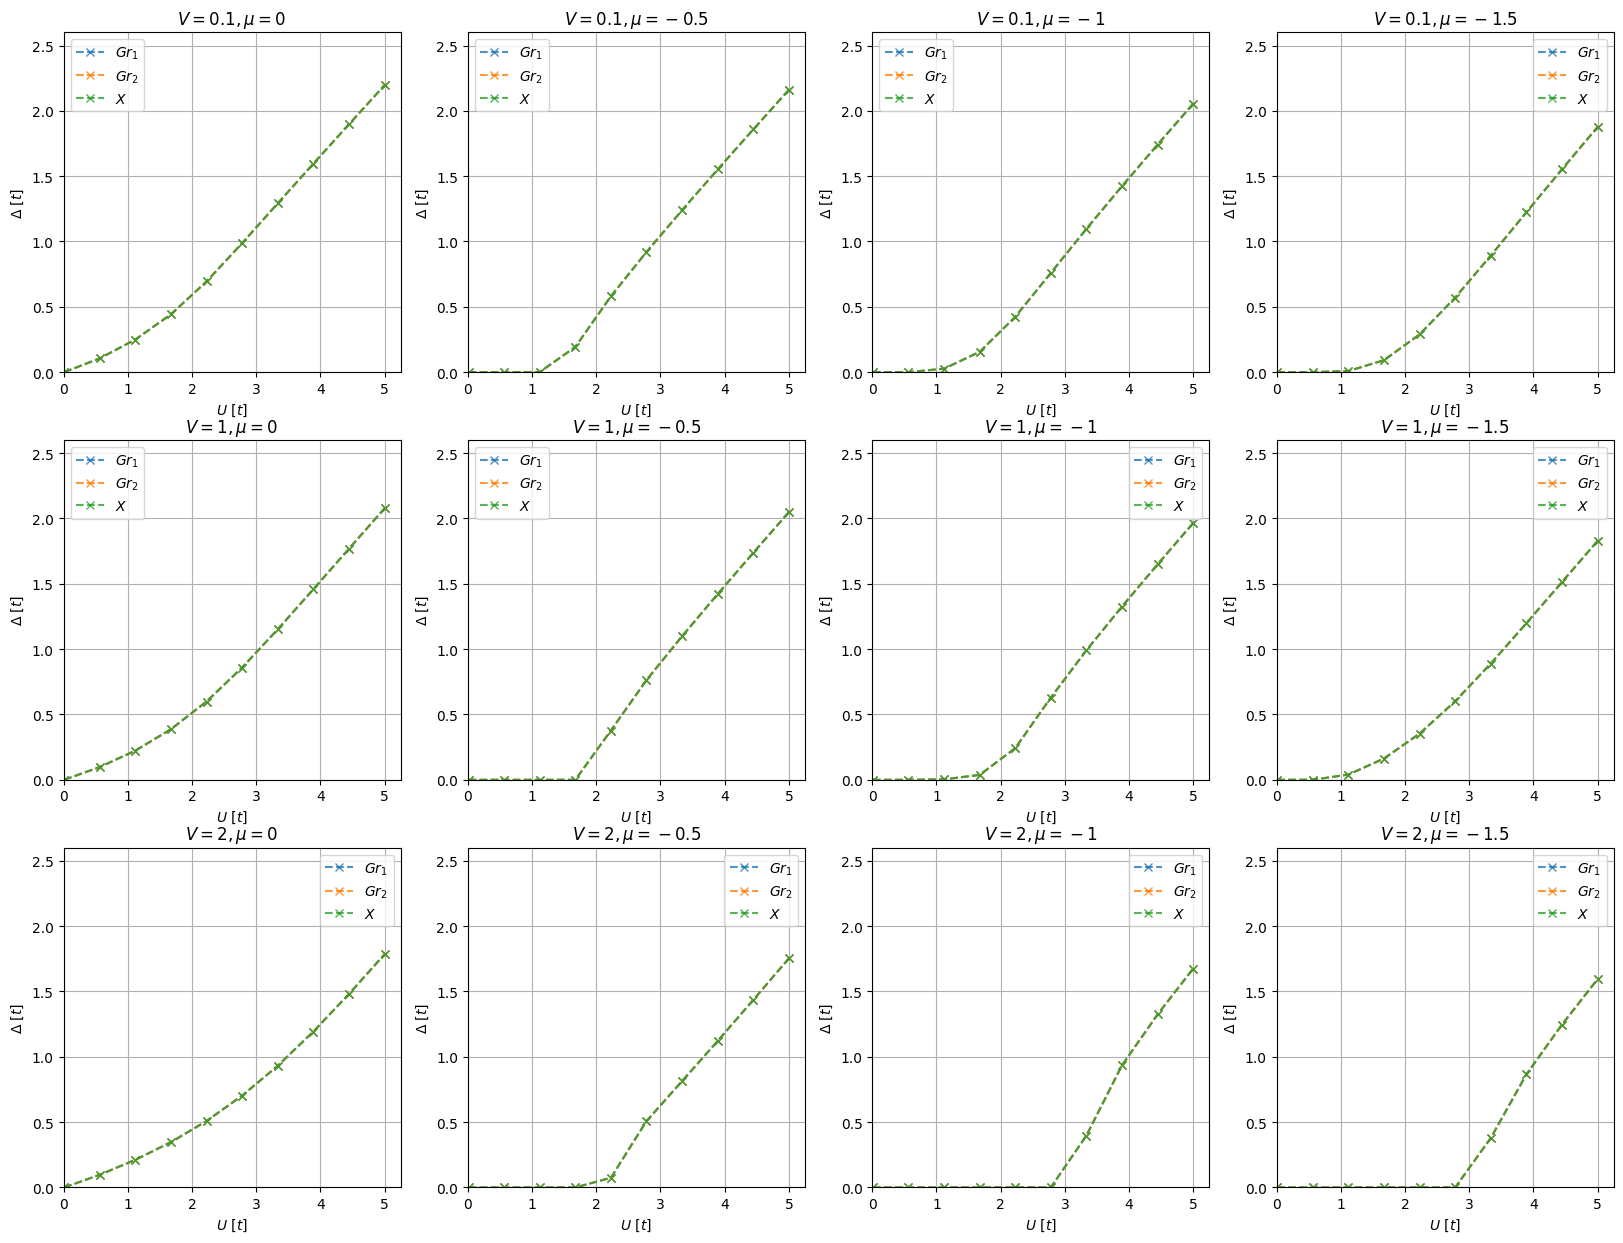

In [85]:
fig = plot_band_basis_uniform_pairing([0.1, 1, 2], 'egx/gap_size_vs_U_uniform_pairing_constraint')
fig.savefig('gap_plots/gap_size_vs_U_band_basis_uniform_pairing_constraint.pdf', bbox_inches='tight')

In [20]:
def plot_for_graphene(base_path):
    mu_files = glob.glob(f'gap_plots_data/{base_path}/*.csv')

    mu_list = sorted([float(x.split('/')[-1].split('_')[-1].strip('.csv')) for x in mu_files], reverse=True)
    print(mu_list)

    fig, ax = plt.subplots(figsize=(5, 5))

    for mu_index, mu in enumerate(mu_list):
        with open(f'gap_plots_data/{base_path}/mu_{mu}.csv', 'r') as f:
            data = pd.read_csv(f, index_col=0)
            
        for row in data.iterrows():
            row[1].loc[['delta_0', 'delta_1']] *= np.sign(row[1].loc['delta_0'])

        ax.plot(data['U'], data['delta_0'], 'x--', label=f'$\\mu = {mu}$')
        #ax.plot(data['U'], data['delta_1'], 'x--', label='$Gr_2$', alpha=0.8)

        ax.set_ylim(bottom=0, top=2.3)
        ax.set_xlim(left=0)
        ax.grid(True)
        ax.set_xlabel(r'$U\ [t]$')
        ax.set_ylabel(r'$\Delta\ [t]$')
        ax.legend()
        ax.set_title(f'$\\mu = {mu}$')

    return fig

[0.0, -0.5, -1.0, -1.5, -2.0]


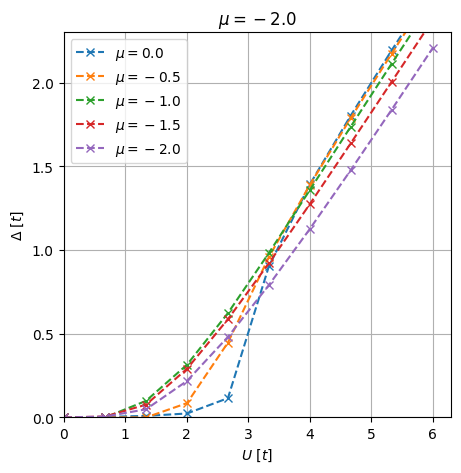

In [21]:
fig = plot_for_graphene('graphene/gap_size_vs_U')
fig.savefig(f'gap_plots/gap_size_vs_U_graphene.pdf')